In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Set plotting style
plt.style.use("default")
sns.set_theme()

## Load Data

In [9]:
df = pd.read_csv("data/NYC_Inspection_data.csv")

## Basic info & missingness

In [10]:
print("Raw shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nPreview:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing value ratio per column:")
print(df.isna().mean().sort_values(ascending=False))

Raw shape: (103426, 26)

Columns:
 ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA']

Preview:
      CAMIS                   DBA           BORO BUILDING             STREET  \
0  41647571         PEKING GARDEN      Manhattan     3163           BROADWAY   
1  50128737           BAO BY KAYA      Manhattan      570   LEXINGTON AVENUE   
2  40510804         WOODROW DINER  Staten Island      655   ROSSVILLE AVENUE   
3  50077566        JANE FAST FOOD         Queens     8622           BROADWAY   
4  50110452  GREENHOUSE CAFE RBNY         Queens    10810  ROCKAWAY BEACH DR   

   ZIPCODE       PHONE CUISINE DESCRIPTION INSPECTION DATE  \
0    10027  2128653600             Chinese        2/1/2022   
1   

## Basic Cleaning

In [11]:
# 1.1 Remove exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows.")

# 1.2 Convert date columns to datetime
date_cols = ["INSPECTION DATE", "GRADE DATE", "RECORD DATE"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# 1.3 Make ZIPCODE a string (to avoid losing leading zeros, and because it's categorical)
df["ZIPCODE"] = df["ZIPCODE"].astype(str)

# 1.4 Treat some columns as categorical
for col in ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE", "GRADE"]:
    df[col] = df[col].astype("category")

Dropped 0 duplicate rows.


## Handling Missing Data

In [12]:
before = df.shape[0]
df = df[~df["SCORE"].isna()]
after = df.shape[0]
print(f"Dropped {before - after} rows with missing SCORE.")

# Focus on grades A, B, C only (simplifies the classification problem)
valid_grades = ["A", "B", "C"]
before = df.shape[0]
df = df[df["GRADE"].isin(valid_grades)]
after = df.shape[0]
print(f"Dropped {before - after} rows with non A/B/C grades or missing grade.")

print("Shape after cleaning:", df.shape)

Dropped 50 rows with missing SCORE.
Dropped 19773 rows with non A/B/C grades or missing grade.
Shape after cleaning: (83603, 26)


## Simple Feature Transformation

In [13]:
# Extract year and month from INSPECTION DATE (useful for EDA and later modeling)
df["INSPECTION_YEAR"] = df["INSPECTION DATE"].dt.year
df["INSPECTION_MONTH"] = df["INSPECTION DATE"].dt.month

## Exploratory Data Analysis (EDA)


Grade counts:
GRADE
A         68421
B          9972
C          5210
Closed        0
N             0
P             0
Z             0
Name: count, dtype: int64


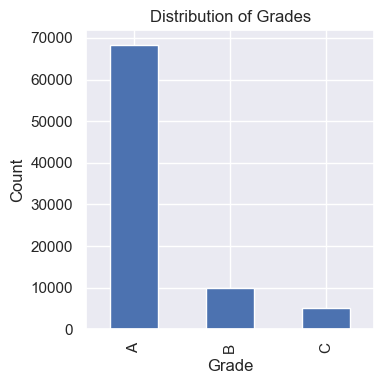

<Figure size 640x480 with 0 Axes>

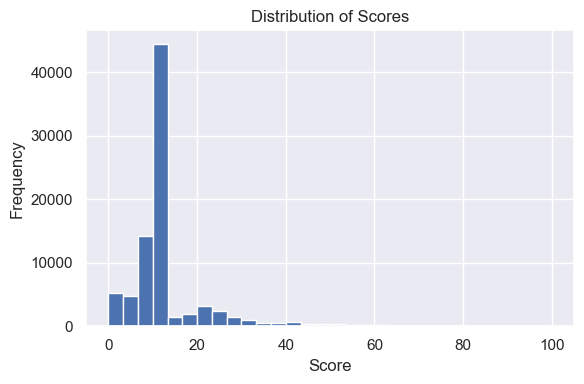


Grades by BORO:
GRADE              A     B     C
BORO                            
Bronx           5943  1020   472
Brooklyn       17929  2722  1456
Manhattan      25955  3366  1844
Queens         15828  2529  1329
Staten Island   2766   335   109


<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

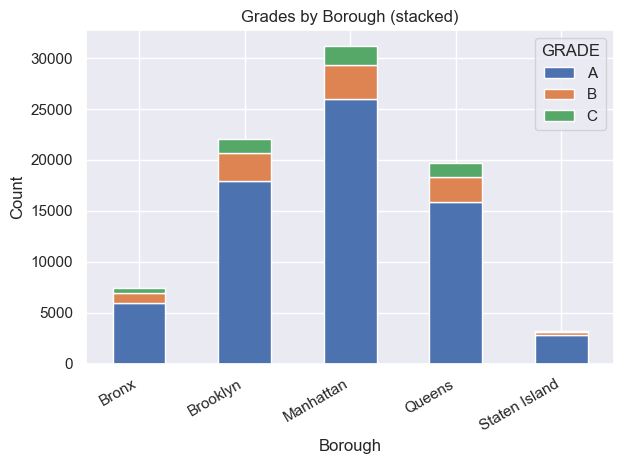


Average SCORE by year:
INSPECTION_YEAR
2012     7.000000
2013     2.500000
2015     8.000000
2016     9.719231
2017    10.506893
2018    11.560417
2019    12.689880
2020    12.378433
2021    12.305988
2022    13.243497
2023    13.889556
Name: SCORE, dtype: float64


<Figure size 640x480 with 0 Axes>

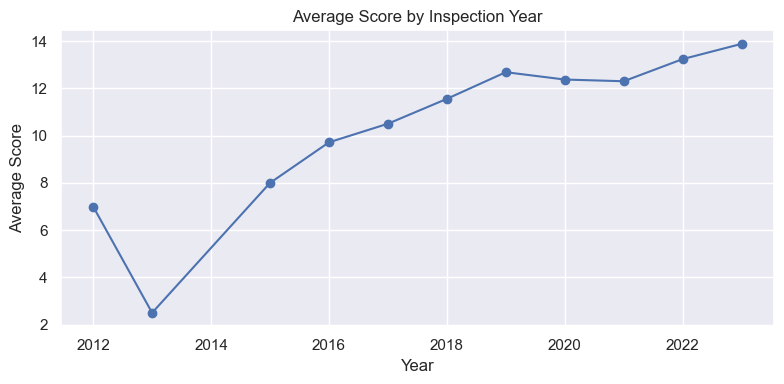

<Figure size 640x480 with 0 Axes>

In [14]:
def show_and_clear():
    plt.tight_layout()
    plt.show()
    plt.clf()

# 4.1 Grade distribution
print("\nGrade counts:")
print(df["GRADE"].value_counts())

plt.figure(figsize=(4, 4))
df["GRADE"].value_counts().loc[["A", "B", "C"]].plot(kind="bar")
plt.title("Distribution of Grades")
plt.xlabel("Grade")
plt.ylabel("Count")
show_and_clear()

# 4.2 Score distribution
plt.figure(figsize=(6, 4))
df["SCORE"].plot(kind="hist", bins=30)
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
show_and_clear()

# 4.3 Grades by borough
print("\nGrades by BORO:")
print(pd.crosstab(df["BORO"], df["GRADE"]))

plt.figure(figsize=(8, 5))
(pd.crosstab(df["BORO"], df["GRADE"])
   .loc[:, ["A", "B", "C"]]
   .plot(kind="bar", stacked=True))
plt.title("Grades by Borough (stacked)")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
show_and_clear()

# 4.4 Average score by year
yearly_scores = df.groupby("INSPECTION_YEAR")["SCORE"].mean().sort_index()
print("\nAverage SCORE by year:")
print(yearly_scores)

plt.figure(figsize=(8, 4))
yearly_scores.plot(marker="o")
plt.title("Average Score by Inspection Year")
plt.xlabel("Year")
plt.ylabel("Average Score")
show_and_clear()

## Simple Feature Engineering

In [15]:
# Set categorical types for key columns used in modeling
for col in ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

## Correlation Checks


=== Cramér’s V (categorical vs GRADE) ===
BORO: 0.0302
CUISINE DESCRIPTION: 0.1514
INSPECTION TYPE: 0.3738

=== Numeric feature differentiation across grades (Kruskal–Wallis) ===
SCORE: p=0.000000e+00
Latitude: p=5.342427e-02
Longitude: p=1.417974e-23


<Figure size 600x400 with 0 Axes>

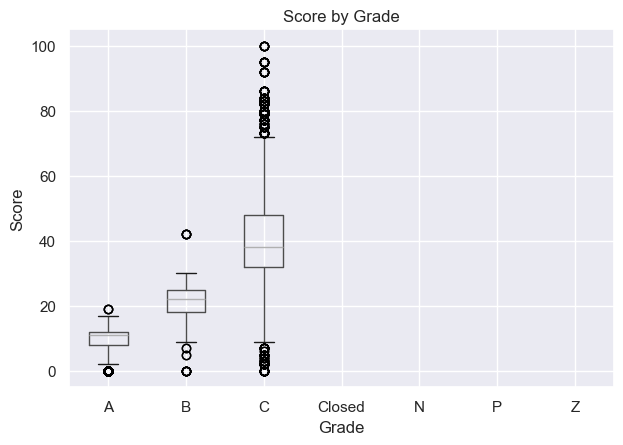

In [16]:
def cramers_v(x, y):
    """Cramér’s V for categorical-categorical association."""
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2_corr = max(0, phi2 - (k - 1)*(r - 1) / (n - 1))
    r_corr = r - (r - 1)**2 / (n - 1)
    k_corr = k - (k - 1)**2 / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

print("\n=== Cramér’s V (categorical vs GRADE) ===")
cat_for_corr = ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE"]
for col in cat_for_corr:
    val = cramers_v(df[col], df["GRADE"])
    print(f"{col}: {val:.4f}")

print("\n=== Numeric feature differentiation across grades (Kruskal–Wallis) ===")
def grade_groups(col):
    return (
        df[df["GRADE"] == "A"][col],
        df[df["GRADE"] == "B"][col],
        df[df["GRADE"] == "C"][col],
    )

for num_col in ["SCORE", "Latitude", "Longitude"]:
    if num_col in df.columns:
        A, B, C = grade_groups(num_col)
        stat, p = kruskal(A, B, C)
        print(f"{num_col}: p={p:.6e}")

# Optional simple plot: score distribution by grade
plt.figure(figsize=(6, 4))
df.boxplot(column="SCORE", by="GRADE")
plt.title("Score by Grade")
plt.suptitle("")
plt.xlabel("Grade")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


## Feature Matrix for Modeling

In [17]:
# --- Pre-inspection features only ---
feature_cols = [
    "Latitude",
    "Longitude",
    "BORO",
    "CUISINE DESCRIPTION",
    "INSPECTION_YEAR",
    "INSPECTION_MONTH",
]

X = df[feature_cols].copy()
y = df["GRADE"].copy()
groups = df["CAMIS"]  # still needed for grouped splitting

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique restaurants:", groups.nunique())

X shape: (83603, 6)
y shape: (83603,)
Unique restaurants: 21165


## Export Model Data to CSV

In [18]:
# Export the 6 features and target to CSV
# Combine features and target into a single DataFrame
export_df = X.copy()
export_df["GRADE"] = y

# Export to CSV
output_file = "Data/model_data.csv"
export_df.to_csv(output_file, index=False)

print(f"Data exported to {output_file}")
print(f"Shape: {export_df.shape}")
print(f"\nColumns exported:")
print(export_df.columns.tolist())
print(f"\nFirst few rows:")
print(export_df.head())
print(f"\nGrade distribution:")
print(export_df["GRADE"].value_counts())

Data exported to Data/model_data.csv
Shape: (83603, 7)

Columns exported:
['Latitude', 'Longitude', 'BORO', 'CUISINE DESCRIPTION', 'INSPECTION_YEAR', 'INSPECTION_MONTH', 'GRADE']

First few rows:
    Latitude  Longitude           BORO CUISINE DESCRIPTION  INSPECTION_YEAR  \
0  40.814647 -73.959057      Manhattan             Chinese             2022   
1  40.756918 -73.972066      Manhattan  Asian/Asian Fusion             2022   
2  40.542592 -74.208331  Staten Island            American             2020   
3  40.738040 -73.877234         Queens             Chinese             2020   
4  40.581404 -73.829873         Queens          Coffee/Tea             2021   

   INSPECTION_MONTH GRADE  
0                 2     A  
1                11     A  
2                 3     A  
3                 2     B  
4                12     A  

Grade distribution:
GRADE
A         68421
B          9972
C          5210
Closed        0
N             0
P             0
Z             0
Name: count, dtype: in

## Grouped 70/30 Train-test Split

In [19]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (58336, 6)
Test size: (25267, 6)


## SMOTE Upsampling for Class Imbalance

=== BEFORE SMOTE ===
Train set class distribution:
GRADE
A         47816
B          6863
C          3657
Closed        0
N             0
P             0
Z             0
Name: count, dtype: int64

Class proportions:
  A: 47,816 (82.0%)
  B: 6,863 (11.8%)
  C: 3,657 (6.3%)

=== AFTER SMOTE ===
Train set class distribution:
GRADE
A    47816
B    47816
C    47816
Name: count, dtype: int64

Class proportions:
  A: 47,816 (33.3%)
  B: 47,816 (33.3%)
  C: 47,816 (33.3%)

Original train size: 58,336
After SMOTE train size: 143,448
Increase: 85,112 samples (145.9%)


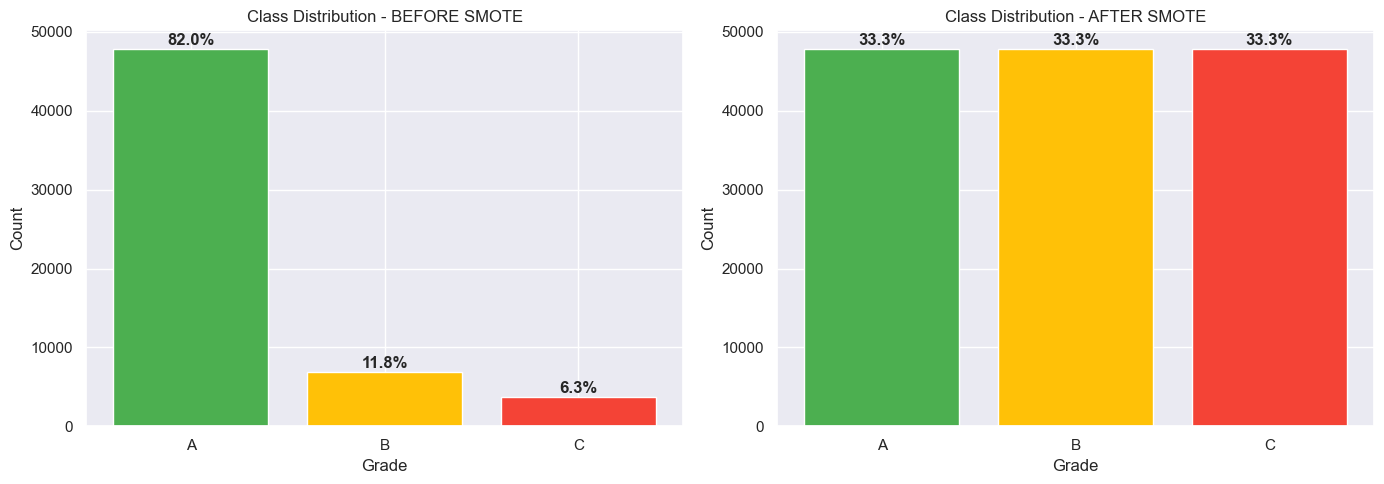

In [20]:
# Apply SMOTE to balance classes B and C
# SMOTE creates synthetic samples for minority classes

print("=== BEFORE SMOTE ===")
print("Train set class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nClass proportions:")
for grade in ["A", "B", "C"]:
    count = (y_train == grade).sum()
    pct = count / len(y_train) * 100
    print(f"  {grade}: {count:,} ({pct:.1f}%)")

# First, we need to preprocess the data before applying SMOTE
# SMOTE works on numeric features, so we need to encode categoricals first
preprocess_temp = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["BORO", "CUISINE DESCRIPTION"]),
        ("num", "passthrough", ["Latitude", "Longitude", "INSPECTION_YEAR", "INSPECTION_MONTH"]),
    ]
)

# Transform training data
X_train_encoded = preprocess_temp.fit_transform(X_train)

# Convert y_train to numeric for SMOTE FIRST (it needs numeric labels)
# This must be done before creating SMOTE with sampling_strategy
label_to_int = {"A": 0, "B": 1, "C": 2}
y_train_encoded = y_train.map(label_to_int)

# Calculate target counts based on encoded labels
# Class 0 (A) is the majority class
target_count_class_0 = (y_train_encoded == 0).sum()

# Apply SMOTE
# Strategy: upsample classes 1 (B) and 2 (C) to match class 0 (A)'s count
# IMPORTANT: Use numeric keys (0, 1, 2) that match the encoded labels
smote = SMOTE(
    sampling_strategy={0: target_count_class_0,  # Keep class 0 (A) as is
                      1: target_count_class_0,  # Upsample class 1 (B) to match A
                      2: target_count_class_0},  # Upsample class 2 (C) to match A
    random_state=42,
    k_neighbors=5  # Number of nearest neighbors for SMOTE
)

# Apply SMOTE
X_train_smote, y_train_smote_encoded = smote.fit_resample(X_train_encoded, y_train_encoded)

# Convert back to original labels
int_to_label = {0: "A", 1: "B", 2: "C"}
y_train_smote = pd.Series(y_train_smote_encoded).map(int_to_label)

print("\n=== AFTER SMOTE ===")
print("Train set class distribution:")
print(y_train_smote.value_counts().sort_index())
print(f"\nClass proportions:")
for grade in ["A", "B", "C"]:
    count = (y_train_smote == grade).sum()
    pct = count / len(y_train_smote) * 100
    print(f"  {grade}: {count:,} ({pct:.1f}%)")

print(f"\nOriginal train size: {len(y_train):,}")
print(f"After SMOTE train size: {len(y_train_smote):,}")
print(f"Increase: {len(y_train_smote) - len(y_train):,} samples ({((len(y_train_smote) / len(y_train)) - 1) * 100:.1f}%)")

# Visualize the class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
before_counts = y_train.value_counts().sort_index()
axes[0].bar(["A", "B", "C"], [before_counts["A"], before_counts["B"], before_counts["C"]], 
            color=["#4CAF50", "#FFC107", "#F44336"])
axes[0].set_title("Class Distribution - BEFORE SMOTE")
axes[0].set_xlabel("Grade")
axes[0].set_ylabel("Count")
for i, grade in enumerate(["A", "B", "C"]):
    count = before_counts[grade]
    pct = count / len(y_train) * 100
    axes[0].text(i, count + 500, f"{pct:.1f}%", ha="center", fontweight="bold")

# After SMOTE
after_counts = y_train_smote.value_counts().sort_index()
axes[1].bar(["A", "B", "C"], [after_counts["A"], after_counts["B"], after_counts["C"]], 
            color=["#4CAF50", "#FFC107", "#F44336"])
axes[1].set_title("Class Distribution - AFTER SMOTE")
axes[1].set_xlabel("Grade")
axes[1].set_ylabel("Count")
for i, grade in enumerate(["A", "B", "C"]):
    count = after_counts[grade]
    pct = count / len(y_train_smote) * 100
    axes[1].text(i, count + 500, f"{pct:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

# Note: X_train_smote is now a numpy array (encoded features)
# We'll need to use this for training models with SMOTE
# The original X_train (DataFrame) is preserved for reference


## Preprocessing for Categorical Variables

In [21]:
categorical_cols = ["BORO", "CUISINE DESCRIPTION"]
numeric_cols = ["Latitude", "Longitude", "INSPECTION_YEAR", "INSPECTION_MONTH"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

## Logistic Regression Model

In [ ]:
# Logistic Regression - Linear baseline model for comparison
# Uses multinomial logistic regression for multi-class classification

def classification_report_df(y_true, y_pred):
    """Convert sklearn classification_report to pandas DataFrame."""
    report = classification_report(y_true, y_pred, output_dict=True)
    return pd.DataFrame(report).transpose()
    
lr_model = LogisticRegression(
    multi_class="multinomial",  # For multi-class classification
    solver="lbfgs",  # Good for small-medium datasets
    max_iter=1500,  # Increase iterations for convergence
    class_weight="balanced",  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Build pipeline: preprocess → model
lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lr_model),
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred = lr_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("=== Logistic Regression TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== Logistic Regression TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred = lr_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== Logistic Regression TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== Logistic Regression TEST CLASSIFICATION REPORT ===")
display(test_report_df)


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression TRAIN ACCURACY === 0.5088281678551838

=== Logistic Regression TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.884699,0.537728,0.668895,47816.000000
B,0.171779,0.312546,0.221705,6863.000000
C,0.108781,0.499316,0.178643,3657.000000
accuracy,0.508828,0.508828,0.508828,0.508828
macro avg,0.388420,0.449863,0.356415,58336.000000
weighted avg,0.752185,0.508828,0.585552,58336.000000



=== Logistic Regression TEST ACCURACY === 0.4847033680294455

=== Logistic Regression TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.876989,0.519000,0.652093,20605.000000
B,0.173641,0.312319,0.223193,3109.000000
C,0.077797,0.374759,0.128847,1553.000000
accuracy,0.484703,0.484703,0.484703,0.484703
macro avg,0.376142,0.402026,0.334711,25267.000000
weighted avg,0.741323,0.484703,0.567158,25267.000000


## Random Forest Classifier

In [23]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_model),
])

pipeline.fit(X_train, y_train)

# --- TRAIN EVAL ---
y_train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("=== Random Forest Classifier TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== Random Forest Classifier TRAIN REPORT ===")
display(train_report_df)


# --- TEST EVAL ---
y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("=== Random Forest Classifier TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== Random Forest Classifier TEST CLASSIFICATION REPORT ===")
display(test_report_df)


=== Random Forest Classifier TRAIN ACCURACY === 0.9994685957213385

=== Random Forest Classifier TRAIN REPORT ===


,precision,recall,f1-score,support
A,1.000000,0.999352,0.999676,47816.000000
B,0.996805,1.000000,0.998400,6863.000000
C,0.997545,1.000000,0.998771,3657.000000
accuracy,0.999469,0.999469,0.999469,0.999469
macro avg,0.998117,0.999784,0.998949,58336.000000
weighted avg,0.999470,0.999469,0.999469,58336.000000


=== Random Forest Classifier TEST ACCURACY === 0.8011239957256501

=== Random Forest Classifier TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.820082,0.973113,0.890068,20605.000000
B,0.231270,0.045674,0.076283,3109.000000
C,0.241379,0.031552,0.055809,1553.000000
accuracy,0.801124,0.801124,0.801124,0.801124
macro avg,0.430910,0.350113,0.340720,25267.000000
weighted avg,0.712062,0.801124,0.738658,25267.000000


## XGBoost Model

In [24]:
# -----------------------------
# 1. Encode labels A/B/C → 0/1/2
# -----------------------------
label_to_int = {"A": 0, "B": 1, "C": 2}
int_to_label = {v: k for k, v in label_to_int.items()}

y_train_enc = y_train.map(label_to_int)
y_test_enc  = y_test.map(label_to_int)

# -----------------------------
# 2. Compute sample weights to handle class imbalance
#    (still based on original labels, that's fine)
# -----------------------------
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# -----------------------------
# 3. Define XGBoost classifier
# -----------------------------
xgb_clf = XGBClassifier(
    objective="multi:softprob",   # probabilistic multi-class
    eval_metric="mlogloss",
    num_class=3,                  # 3 grades: A, B, C
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# 4. Build pipeline: preprocess → model
# -----------------------------
xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_clf),
])

# -----------------------------
# 5. Train with encoded labels
# -----------------------------
xgb_pipeline.fit(
    X_train,
    y_train_enc,
    model__sample_weight=sample_weights
)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred_enc = xgb_pipeline.predict(X_train)
# convert back to A/B/C for reporting
y_train_pred = pd.Series(y_train_pred_enc).map(int_to_label)

train_acc = accuracy_score(y_train, y_train_pred)
print("=== XGBoost TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== XGBoost TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred_enc = xgb_pipeline.predict(X_test)
y_test_pred = pd.Series(y_test_pred_enc).map(int_to_label)

test_acc = accuracy_score(y_test, y_test_pred)
print("\n=== XGBoost TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== XGBoost TEST CLASSIFICATION REPORT ===")
display(test_report_df)


=== XGBoost TRAIN ACCURACY === 0.6747805814591333

=== XGBoost TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.949277,0.660281,0.778834,47816.000000
B,0.316339,0.697071,0.435186,6863.000000
C,0.302190,0.822532,0.441995,3657.000000
accuracy,0.674781,0.674781,0.674781,0.674781
macro avg,0.522602,0.726628,0.552005,58336.000000
weighted avg,0.834249,0.674781,0.717290,58336.000000



=== XGBoost TEST ACCURACY === 0.5773934380812918

=== XGBoost TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.890327,0.624460,0.734062,20605.000000
B,0.199529,0.436153,0.273801,3109.000000
C,0.091067,0.235673,0.131371,1553.000000
accuracy,0.577393,0.577393,0.577393,0.577393
macro avg,0.393641,0.432095,0.379745,25267.000000
weighted avg,0.756202,0.577393,0.640385,25267.000000


## Models with SMOTE Upsampling

In [32]:
# Train models using SMOTE-upsampled data
# Note: X_train_smote is already preprocessed (encoded), so we'll train directly on it
# X_test still needs to be preprocessed using the same preprocessor

# Preprocess test data using the same preprocessor
X_test_encoded = preprocess_temp.transform(X_test)

print("=" * 70)
print("TRAINING MODELS WITH SMOTE-UPSAMPLED DATA")
print("=" * 70)

# ============================================
# 1. Random Forest with SMOTE
# ============================================
print("\n[1/3] Training Random Forest with SMOTE...")
rf_smote = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
    # Note: No class_weight needed since classes are balanced
)

rf_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_rf = pd.Series(rf_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_rf = pd.Series(rf_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_rf = accuracy_score(y_train_smote, y_train_pred_smote_rf)
test_acc_smote_rf = accuracy_score(y_test, y_test_pred_smote_rf)

print(f"  Train Accuracy: {train_acc_smote_rf:.4f}")
print(f"  Test Accuracy: {test_acc_smote_rf:.4f}")

# ============================================
# 2. XGBoost with SMOTE
# ============================================
print("\n[2/3] Training XGBoost with SMOTE...")
xgb_smote = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
    # Note: No sample weights needed since classes are balanced
)

xgb_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_xgb = pd.Series(xgb_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_xgb = pd.Series(xgb_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_xgb = accuracy_score(y_train_smote, y_train_pred_smote_xgb)
test_acc_smote_xgb = accuracy_score(y_test, y_test_pred_smote_xgb)

print(f"  Train Accuracy: {train_acc_smote_xgb:.4f}")
print(f"  Test Accuracy: {test_acc_smote_xgb:.4f}")

# ============================================
# 3. Logistic Regression with SMOTE
# ============================================
print("\n[3/3] Training Logistic Regression with SMOTE...")
lr_smote = LogisticRegression(
    solver="lbfgs",
    max_iter=1500,
    random_state=42,
    n_jobs=-1
    # Note: No class_weight needed since classes are balanced
)

lr_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_lr = pd.Series(lr_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_lr = pd.Series(lr_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_lr = accuracy_score(y_train_smote, y_train_pred_smote_lr)
test_acc_smote_lr = accuracy_score(y_test, y_test_pred_smote_lr)

print(f"  Train Accuracy: {train_acc_smote_lr:.4f}")
print(f"  Test Accuracy: {test_acc_smote_lr:.4f}")

print("\n" + "=" * 70)


TRAINING MODELS WITH SMOTE-UPSAMPLED DATA

[1/3] Training Random Forest with SMOTE...
  Train Accuracy: 0.9998
  Test Accuracy: 0.7845

[2/3] Training XGBoost with SMOTE...
  Train Accuracy: 0.6893
  Test Accuracy: 0.5831

[3/3] Training Logistic Regression with SMOTE...
  Train Accuracy: 0.4528
  Test Accuracy: 0.4881



/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## SMOTE vs Class Weight Comparison

COMPARISON: Class Weight vs SMOTE Upsampling

Test Set Accuracy Comparison:


,Model,Class Weight (Test Acc),SMOTE (Test Acc),Improvement
0,Random Forest,0.8011,0.7845,-1.6662
1,XGBoost,0.5774,0.5831,0.5739
2,Logistic Regression,0.4847,0.4881,0.3443


DETAILED PER-CLASS METRICS: Logistic Regression

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.8770,0.5190,0.6521,20605.0000
B,0.1736,0.3123,0.2232,3109.0000
C,0.0778,0.3748,0.1288,1553.0000
accuracy,0.4847,0.4847,0.4847,0.4847
macro avg,0.3761,0.4020,0.3347,25267.0000
weighted avg,0.7413,0.4847,0.5672,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.8747,0.5246,0.6559,20605.0000
B,0.1676,0.2956,0.2139,3109.0000
C,0.0815,0.3896,0.1348,1553.0000
accuracy,0.4881,0.4881,0.4881,0.4881
macro avg,0.3746,0.4033,0.3349,25267.0000
weighted avg,0.7389,0.4881,0.5695,25267.0000



DETAILED PER-CLASS METRICS: Random Forest

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.8201,0.9731,0.8901,20605.0000
B,0.2313,0.0457,0.0763,3109.0000
C,0.2414,0.0316,0.0558,1553.0000
accuracy,0.8011,0.8011,0.8011,0.8011
macro avg,0.4309,0.3501,0.3407,25267.0000
weighted avg,0.7121,0.8011,0.7387,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.8240,0.9455,0.8806,20605.0000
B,0.2050,0.0868,0.1220,3109.0000
C,0.2230,0.0438,0.0732,1553.0000
accuracy,0.7845,0.7845,0.7845,0.7845
macro avg,0.4173,0.3587,0.3586,25267.0000
weighted avg,0.7109,0.7845,0.7376,25267.0000



DETAILED PER-CLASS METRICS: XGBoost

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.8903,0.6245,0.7341,20605.0000
B,0.1995,0.4362,0.2738,3109.0000
C,0.0911,0.2357,0.1314,1553.0000
accuracy,0.5774,0.5774,0.5774,0.5774
macro avg,0.3936,0.4321,0.3797,25267.0000
weighted avg,0.7562,0.5774,0.6404,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.8876,0.6346,0.7401,20605.0000
B,0.1998,0.4146,0.2696,3109.0000
C,0.0906,0.2382,0.1313,1553.0000
accuracy,0.5831,0.5831,0.5831,0.5831
macro avg,0.3927,0.4291,0.3803,25267.0000
weighted avg,0.7540,0.5831,0.6448,25267.0000


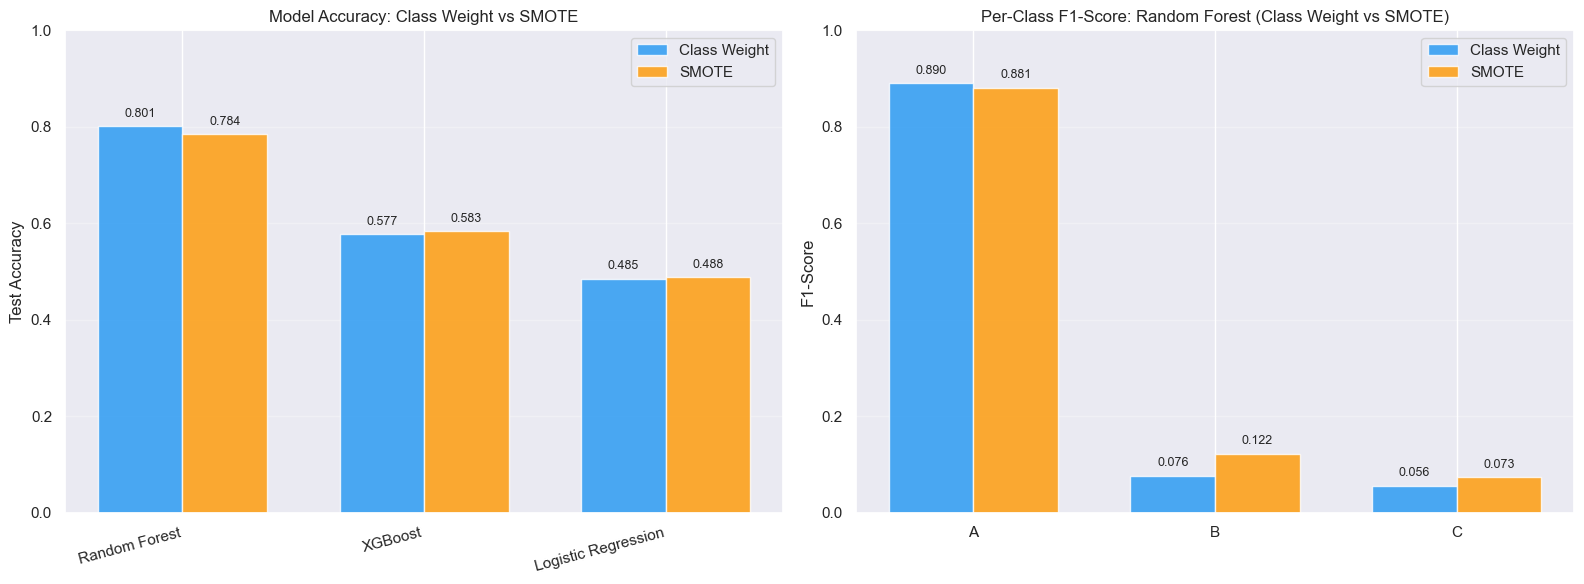

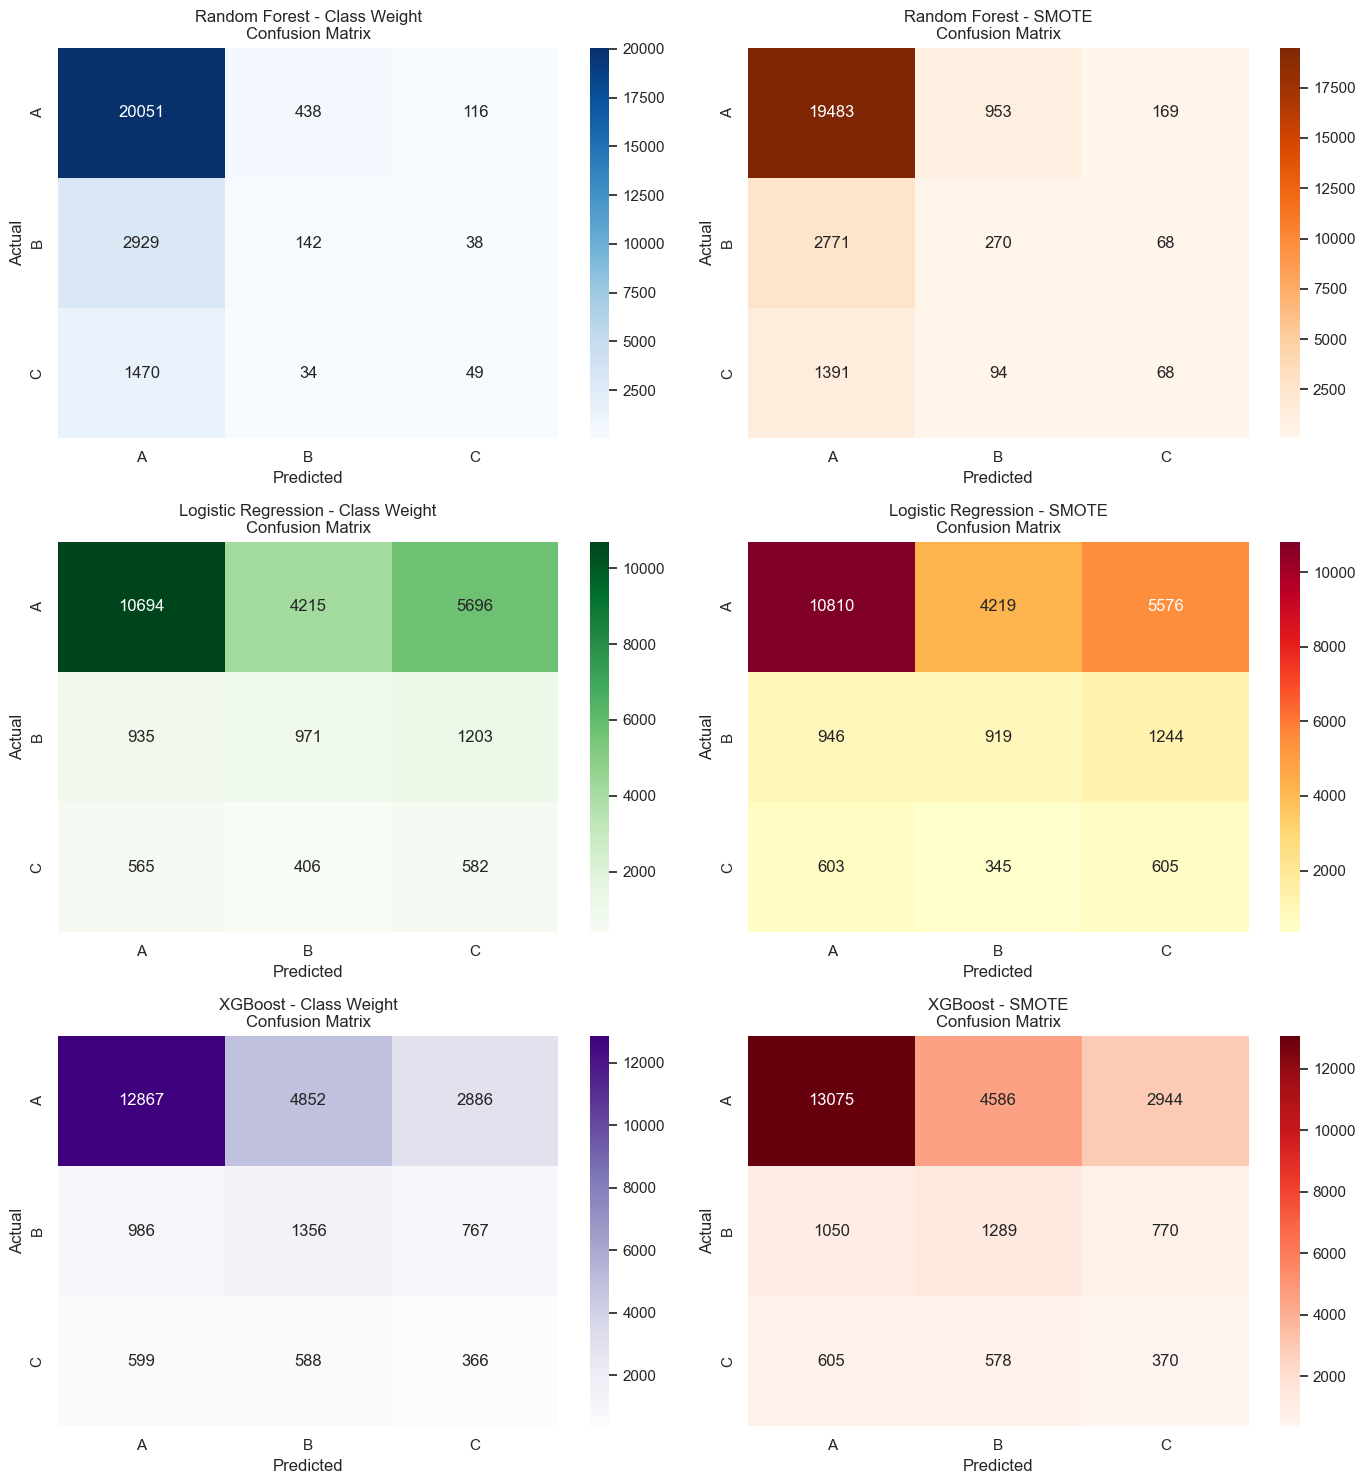


KEY INSIGHTS:
1. SMOTE creates synthetic samples for minority classes (B and C)
2. This should improve recall for B and C classes
3. Compare the confusion matrices to see if B/C predictions improved
4. Check if overall accuracy improved or if it's a trade-off


In [ ]:
# Comprehensive comparison: SMOTE vs Class Weight approaches

# Get original model accuracies (from previous cells)
rf_acc_original = accuracy_score(y_test, pipeline.predict(X_test))
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_acc_original = accuracy_score(y_test, xgb_preds_original)
lr_acc_original = accuracy_score(y_test, lr_pipeline.predict(X_test))

# Create comparison DataFrame
comparison_data = {
    "Model": ["Random Forest", "XGBoost", "Logistic Regression"],
    "Class Weight (Test Acc)": [rf_acc_original, xgb_acc_original, lr_acc_original],
    "SMOTE (Test Acc)": [test_acc_smote_rf, test_acc_smote_xgb, test_acc_smote_lr],
    "Improvement": [
        test_acc_smote_rf - rf_acc_original,
        test_acc_smote_xgb - xgb_acc_original,
        test_acc_smote_lr - lr_acc_original
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Improvement"] = comparison_df["Improvement"] * 100  # Convert to percentage points

print("=" * 70)
print("COMPARISON: Class Weight vs SMOTE Upsampling")
print("=" * 70)
print("\nTest Set Accuracy Comparison:")
display(comparison_df.round(4))

# Detailed per-class metrics for Logistic Regression
print("=" * 70)
print("DETAILED PER-CLASS METRICS: Logistic Regression")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
lr_report_original = classification_report(y_test, lr_pipeline.predict(X_test), output_dict=True)
lr_df_original = pd.DataFrame(lr_report_original).transpose()
display(lr_df_original.round(4))

print("\n--- WITH SMOTE ---")
lr_report_smote = classification_report(y_test, y_test_pred_smote_lr, output_dict=True)
lr_df_smote = pd.DataFrame(lr_report_smote).transpose()
display(lr_df_smote.round(4))

# Detailed per-class metrics for Random Forest
print("\n" + "=" * 70)
print("DETAILED PER-CLASS METRICS: Random Forest")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
rf_report_original = classification_report(y_test, pipeline.predict(X_test), output_dict=True)
rf_df_original = pd.DataFrame(rf_report_original).transpose()
display(rf_df_original.round(4))

print("\n--- WITH SMOTE ---")
rf_report_smote = classification_report(y_test, y_test_pred_smote_rf, output_dict=True)
rf_df_smote = pd.DataFrame(rf_report_smote).transpose()
display(rf_df_smote.round(4))

# Detailed per-class metrics for XGBoost
print("\n" + "=" * 70)
print("DETAILED PER-CLASS METRICS: XGBoost")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_report_original = classification_report(y_test, xgb_preds_original, output_dict=True)
xgb_df_original = pd.DataFrame(xgb_report_original).transpose()
display(xgb_df_original.round(4))

print("\n--- WITH SMOTE ---")
xgb_report_smote = classification_report(y_test, y_test_pred_smote_xgb, output_dict=True)
xgb_df_smote = pd.DataFrame(xgb_report_smote).transpose()
display(xgb_df_smote.round(4))


# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy comparison bar chart
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df["Class Weight (Test Acc)"], width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[0].bar(x + width/2, comparison_df["SMOTE (Test Acc)"], width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[0].set_ylabel("Test Accuracy")
axes[0].set_title("Model Accuracy: Class Weight vs SMOTE")
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df["Model"], rotation=15, ha="right")
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# Add value labels
for i, (orig, smote) in enumerate(zip(comparison_df["Class Weight (Test Acc)"], 
                                       comparison_df["SMOTE (Test Acc)"])):
    axes[0].text(i - width/2, orig + 0.02, f"{orig:.3f}", ha="center", fontsize=9)
    axes[0].text(i + width/2, smote + 0.02, f"{smote:.3f}", ha="center", fontsize=9)

# 2. Per-class F1 score comparison (Random Forest)
classes = ["A", "B", "C"]
f1_class_weight = [rf_report_original[cls]["f1-score"] for cls in classes]
f1_smote = [rf_report_smote[cls]["f1-score"] for cls in classes]

x2 = np.arange(len(classes))
axes[1].bar(x2 - width/2, f1_class_weight, width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[1].bar(x2 + width/2, f1_smote, width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[1].set_ylabel("F1-Score")
axes[1].set_title("Per-Class F1-Score: Random Forest (Class Weight vs SMOTE)")
axes[1].set_xticks(x2)
axes[1].set_xticklabels(classes)
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

# Add value labels
for i, (cw, sm) in enumerate(zip(f1_class_weight, f1_smote)):
    axes[1].text(i - width/2, cw + 0.02, f"{cw:.3f}", ha="center", fontsize=9)
    axes[1].text(i + width/2, sm + 0.02, f"{sm:.3f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

# Confusion matrices comparison - All Models
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Row 1: Logistic Regression
# Class Weight confusion matrix
cm_lr_original = confusion_matrix(y_test, lr_pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(cm_lr_original, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1, 0])
axes[1, 0].set_title("Logistic Regression - Class Weight\nConfusion Matrix")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_lr_smote = confusion_matrix(y_test, y_test_pred_smote_lr, labels=["A", "B", "C"])
sns.heatmap(cm_lr_smote, annot=True, fmt="d", cmap="YlOrRd", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1, 1])
axes[1, 1].set_title("Logistic Regression - SMOTE\nConfusion Matrix")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")

# Row 2: Random Forest
# Class Weight confusion matrix
cm_rf_original = confusion_matrix(y_test, pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(cm_rf_original, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[0, 0])
axes[0, 0].set_title("Random Forest - Class Weight\nConfusion Matrix")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_rf_smote = confusion_matrix(y_test, y_test_pred_smote_rf, labels=["A", "B", "C"])
sns.heatmap(cm_rf_smote, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[0, 1])
axes[0, 1].set_title("Random Forest - SMOTE\nConfusion Matrix")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("Actual")

# Row 3: XGBoost
# Class Weight confusion matrix
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
cm_xgb_original = confusion_matrix(y_test, xgb_preds_original, labels=["A", "B", "C"])
sns.heatmap(cm_xgb_original, annot=True, fmt="d", cmap="Purples", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[2, 0])
axes[2, 0].set_title("XGBoost - Class Weight\nConfusion Matrix")
axes[2, 0].set_xlabel("Predicted")
axes[2, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_xgb_smote = confusion_matrix(y_test, y_test_pred_smote_xgb, labels=["A", "B", "C"])
sns.heatmap(cm_xgb_smote, annot=True, fmt="d", cmap="Reds", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[2, 1])
axes[2, 1].set_title("XGBoost - SMOTE\nConfusion Matrix")
axes[2, 1].set_xlabel("Predicted")
axes[2, 1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
print("1. SMOTE creates synthetic samples for minority classes (B and C)")
print("2. This should improve recall for B and C classes")
print("3. Compare the confusion matrices to see if B/C predictions improved")
print("4. Check if overall accuracy improved or if it's a trade-off")
print("=" * 70)


## Confusion Matrix Heatmaps

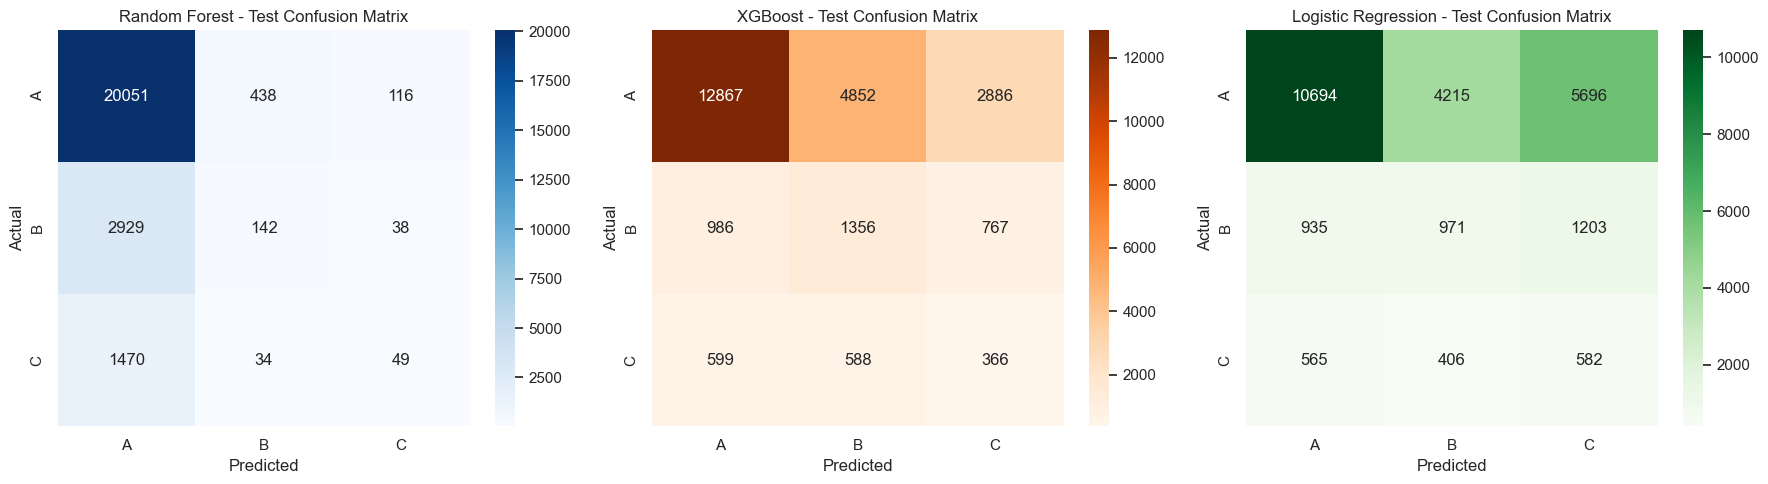

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Logistic Regression confusion matrix
lr_cm = confusion_matrix(y_test, lr_pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Greens", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[2])
axes[2].set_title("Logistic Regression - Test Confusion Matrix")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

# Random Forest confusion matrix
rf_cm = confusion_matrix(y_test, pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[0])
axes[0].set_title("Random Forest - Test Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# XGBoost confusion matrix
xgb_preds = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_cm = confusion_matrix(y_test, xgb_preds, labels=["A", "B", "C"])
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Oranges", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1])
axes[1].set_title("XGBoost - Test Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## Feature Importance

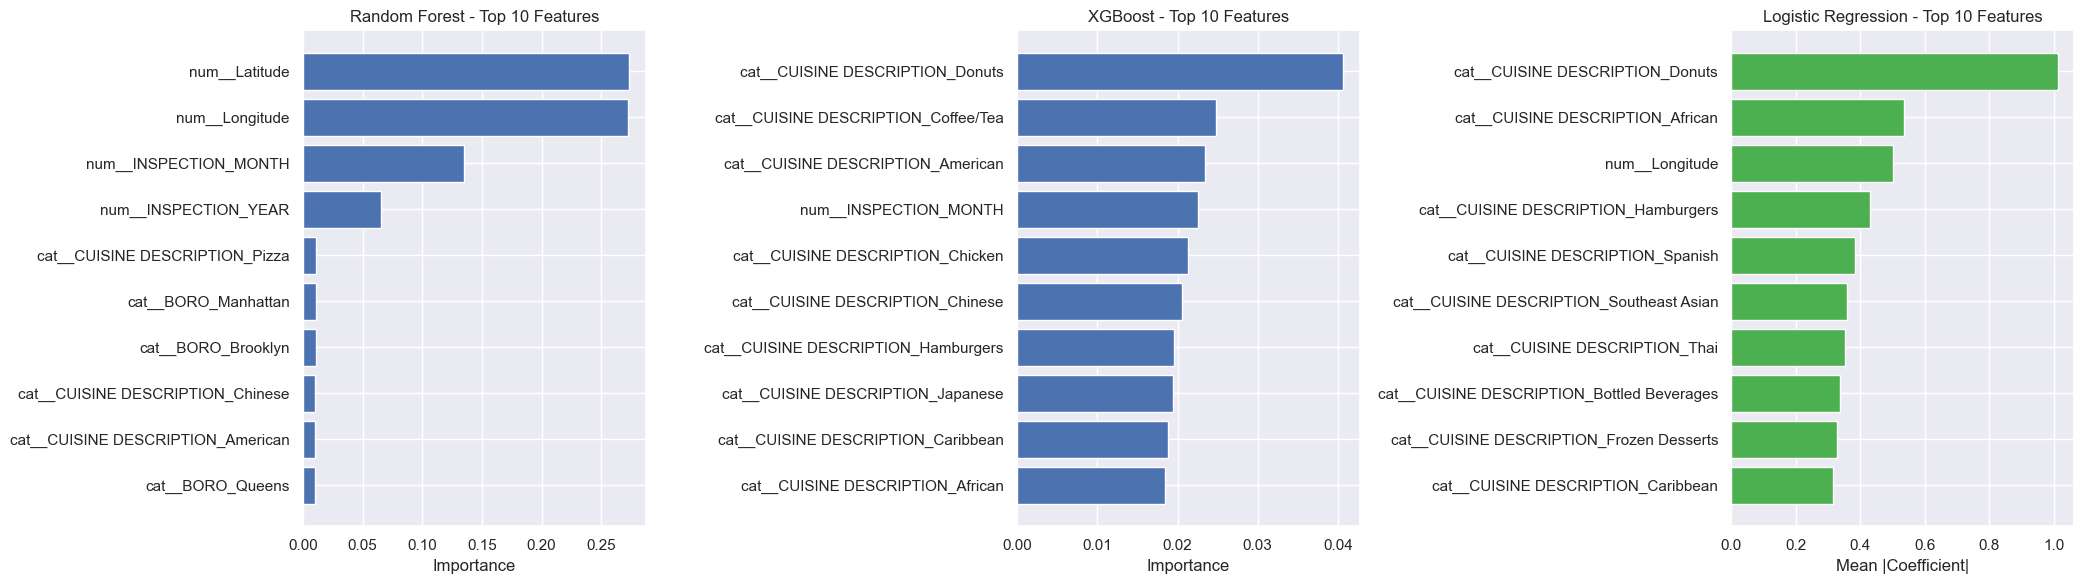

In [28]:
# Feature Importance Comparison
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Get feature names from the preprocessor
feature_names = preprocess.get_feature_names_out()

# Logistic Regression feature importance (using absolute coefficient values)
# For multinomial logistic regression, use mean absolute coefficients across all classes
lr_coef = lr_pipeline.named_steps["model"].coef_  # Shape: (n_classes, n_features)
lr_importances = np.mean(np.abs(lr_coef), axis=0)  # Average absolute coefficients across classes
lr_top_idx = lr_importances.argsort()[-10:][::-1]
axes[2].barh(range(10), lr_importances[lr_top_idx][::-1], color="#4CAF50")
axes[2].set_yticks(range(10))
axes[2].set_yticklabels([feature_names[i] for i in lr_top_idx][::-1])
axes[2].set_xlabel("Mean |Coefficient|")
axes[2].set_title("Logistic Regression - Top 10 Features")

# Random Forest feature importance
rf_importances = pipeline.named_steps["model"].feature_importances_
rf_top_idx = rf_importances.argsort()[-10:][::-1]
axes[0].barh(range(10), rf_importances[rf_top_idx][::-1])
axes[0].set_yticks(range(10))
axes[0].set_yticklabels([feature_names[i] for i in rf_top_idx][::-1])
axes[0].set_xlabel("Importance")
axes[0].set_title("Random Forest - Top 10 Features")

# XGBoost feature importance
xgb_importances = xgb_pipeline.named_steps["model"].feature_importances_
xgb_top_idx = xgb_importances.argsort()[-10:][::-1]
axes[1].barh(range(10), xgb_importances[xgb_top_idx][::-1])
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([feature_names[i] for i in xgb_top_idx][::-1])
axes[1].set_xlabel("Importance")
axes[1].set_title("XGBoost - Top 10 Features")

plt.tight_layout()
plt.show()

## Summary Dashboard

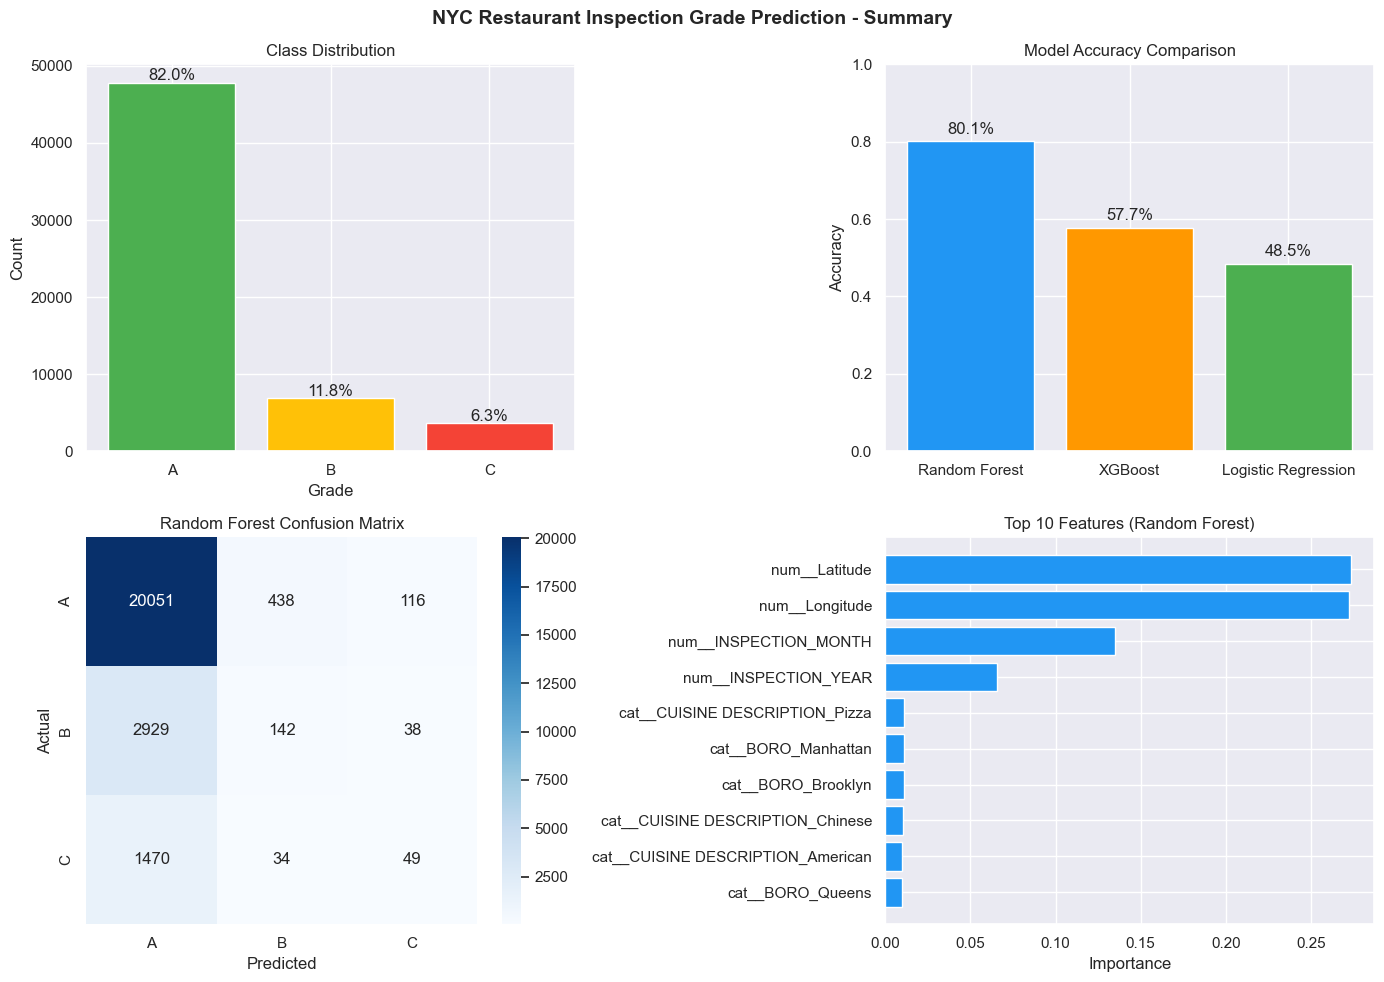

In [29]:
# Executive Summary Dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class Distribution (top left)
grade_counts = y_train.value_counts().sort_index()
colors = ["#4CAF50", "#FFC107", "#F44336"]
bars = axes[0, 0].bar(["A", "B", "C"], [grade_counts["A"], grade_counts["B"], grade_counts["C"]], color=colors)
axes[0, 0].set_title("Class Distribution")
axes[0, 0].set_xlabel("Grade")
axes[0, 0].set_ylabel("Count")
total = grade_counts.sum()
for bar, grade in zip(bars, ["A", "B", "C"]):
    pct = grade_counts[grade] / total * 100
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 300, f"{pct:.1f}%", ha="center")

# 2. Model Comparison (top right)
models = ["Random Forest", "XGBoost", "Logistic Regression"]
rf_acc = accuracy_score(y_test, pipeline.predict(X_test))
xgb_preds = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_acc = accuracy_score(y_test, xgb_preds)
lr_acc = accuracy_score(y_test, lr_pipeline.predict(X_test))
axes[0, 1].bar(models, [rf_acc, xgb_acc, lr_acc], color=["#2196F3", "#FF9800", "#4CAF50"])
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_title("Model Accuracy Comparison")
axes[0, 1].set_ylabel("Accuracy")
for i, acc in enumerate([rf_acc, xgb_acc, lr_acc]):
    axes[0, 1].text(i, acc + 0.02, f"{acc:.1%}", ha="center")

# 3. Best Model Confusion Matrix (bottom left)
rf_cm = confusion_matrix(y_test, pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1, 0])
axes[1, 0].set_title("Random Forest Confusion Matrix")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

# 4. Top 10 Features (bottom right)
feature_names = preprocess.get_feature_names_out()
rf_importances = pipeline.named_steps["model"].feature_importances_
top_idx = rf_importances.argsort()[-10:][::-1]
axes[1, 1].barh(range(10), rf_importances[top_idx][::-1], color="#2196F3")
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_yticklabels([feature_names[i] for i in top_idx][::-1])
axes[1, 1].set_title("Top 10 Features (Random Forest)")
axes[1, 1].set_xlabel("Importance")

plt.suptitle("NYC Restaurant Inspection Grade Prediction - Summary", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Geographic Distribution

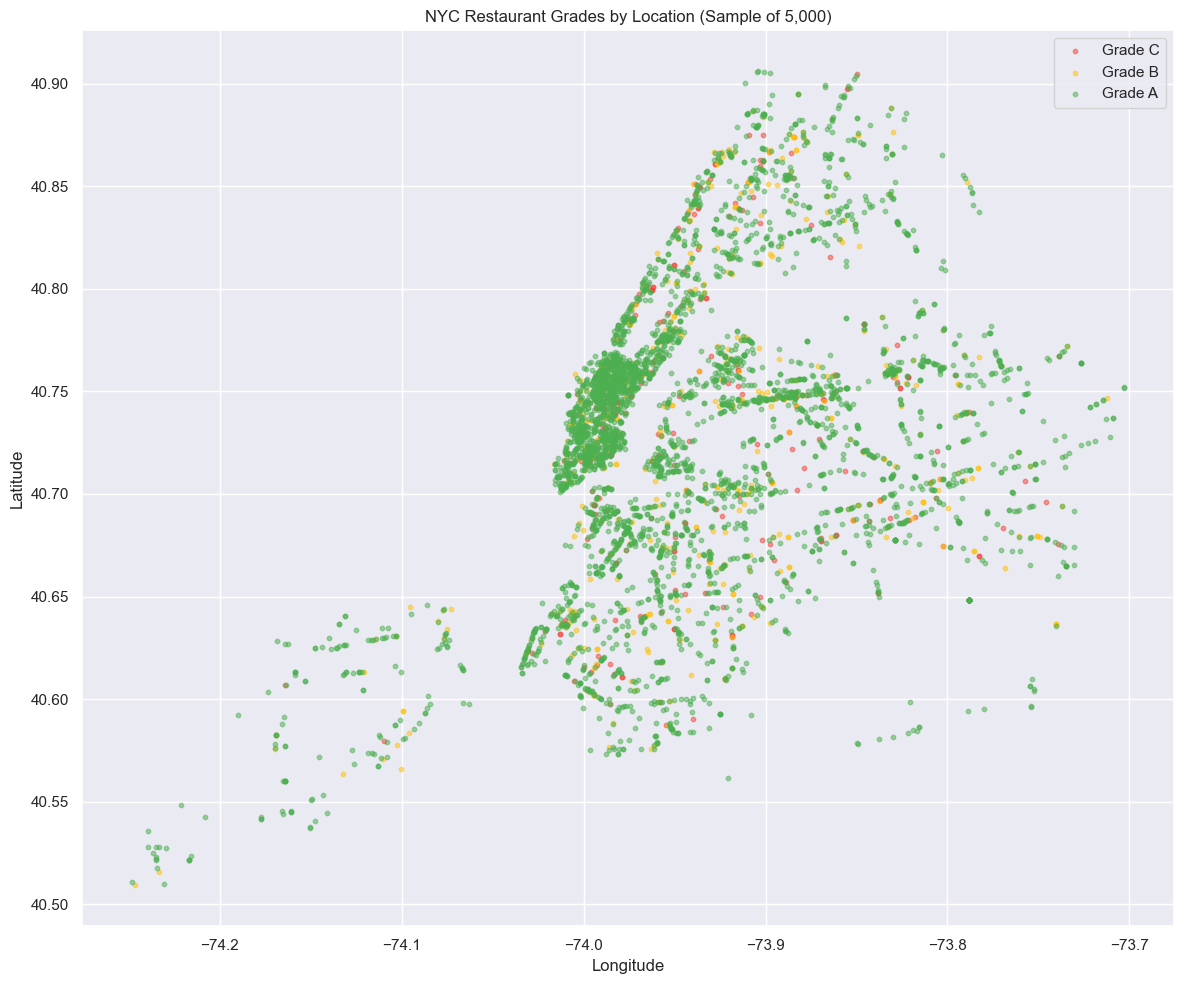

In [30]:
# Geographic Distribution of Grades
fig, ax = plt.subplots(figsize=(12, 10))

# Sample for performance (plotting 80k+ points is slow)
sample_df = df.sample(n=5000, random_state=42)

colors_map = {"A": "#4CAF50", "B": "#FFC107", "C": "#F44336"}
for grade in ["C", "B", "A"]:  # Plot A last so it doesn't cover the others
    subset = sample_df[sample_df["GRADE"] == grade]
    ax.scatter(subset["Longitude"], subset["Latitude"], 
               c=colors_map[grade], label=f"Grade {grade}", alpha=0.5, s=10)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NYC Restaurant Grades by Location (Sample of 5,000)")
ax.legend()
plt.tight_layout()
plt.show()

## Model Performance Comparison

=== MODEL PERFORMANCE COMPARISON (TEST SET) ===



,Random Forest,XGBoost,Logistic Regression,Winner
Accuracy,0.8011,0.5774,0.4847,Random Forest
Precision,0.7121,0.7562,0.7413,XGBoost
Recall,0.8011,0.5774,0.4847,Random Forest
F1-Score,0.7387,0.6404,0.5672,Random Forest


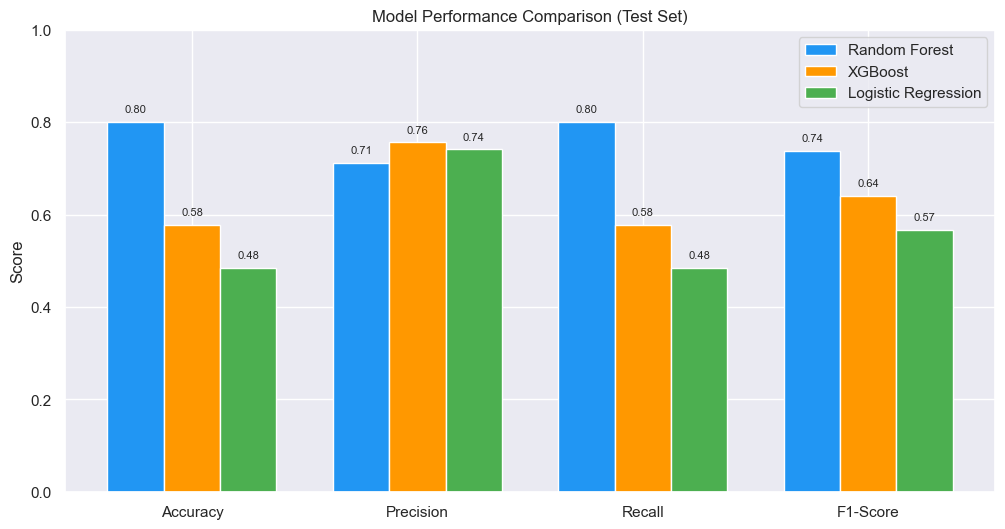

In [31]:
# Get predictions
rf_preds = pipeline.predict(X_test)
xgb_preds_encoded = xgb_pipeline.predict(X_test)
xgb_preds = pd.Series(xgb_preds_encoded).map({0: "A", 1: "B", 2: "C"})
lr_preds = lr_pipeline.predict(X_test)

# Calculate metrics (weighted average to handle imbalance)
metrics = {
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds),
        accuracy_score(y_test, lr_preds)
    ],
    "Precision": [
        precision_score(y_test, rf_preds, average="weighted"),
        precision_score(y_test, xgb_preds, average="weighted"),
        precision_score(y_test, lr_preds, average="weighted")
    ],
    "Recall": [
        recall_score(y_test, rf_preds, average="weighted"),
        recall_score(y_test, xgb_preds, average="weighted"),
        recall_score(y_test, lr_preds, average="weighted")
    ],
    "F1-Score": [
        f1_score(y_test, rf_preds, average="weighted"),
        f1_score(y_test, xgb_preds, average="weighted"),
        f1_score(y_test, lr_preds, average="weighted")
    ]
}

# Create summary table
summary_df = pd.DataFrame(metrics, index=["Random Forest", "XGBoost", "Logistic Regression"]).T
summary_df["Winner"] = summary_df.idxmax(axis=1)
print("=== MODEL PERFORMANCE COMPARISON (TEST SET) ===\n")
display(summary_df.round(4))

# Plot
x = np.arange(len(metrics))
width = 0.25  # CHANGE from 0.35 to 0.25

fig, ax = plt.subplots(figsize=(12, 6))  # CHANGE from (10, 6) to (12, 6)
bars1 = ax.bar(x - width, [metrics[m][0] for m in metrics], width, label="Random Forest", color="#2196F3")
bars2 = ax.bar(x, [metrics[m][1] for m in metrics], width, label="XGBoost", color="#FF9800")
bars3 = ax.bar(x + width, [metrics[m][2] for m in metrics], width, label="Logistic Regression", color="#4CAF50")  # ADD THIS

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison (Test Set)")
ax.set_xticks(x)
ax.set_xticklabels(metrics.keys())
ax.set_ylim(0, 1)
ax.legend()

# Add value labels
for bars in [bars1, bars2, bars3]:  # UPDATE THIS
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f"{bar.get_height():.2f}", ha="center", fontsize=8)  # UPDATE fontsize to 8